# Setup

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# MNIST

In [2]:
from scipy.io import arff
import pandas as pd
import numpy as np

data, meta = arff.loadarff("data/mnist_784.arff")

df = pd.DataFrame(data)

X = df.iloc[:, :-1].values.astype(np.float32)  
y = df.iloc[:, -1].values.astype(str)  

y = np.array([int(label) for label in y])




In [3]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
X.shape

(70000, 784)

There are 70,000 images, and each image has 784 features. Each iamge = 28 x 28 pixels = 784 features, each feature one pixel's intensity from 0 (white) yo 255 (black)

In [5]:
y

array([5, 0, 4, ..., 4, 5, 6])

In [6]:
y.shape

(70000,)

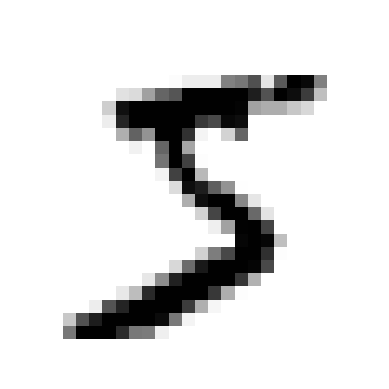

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

5

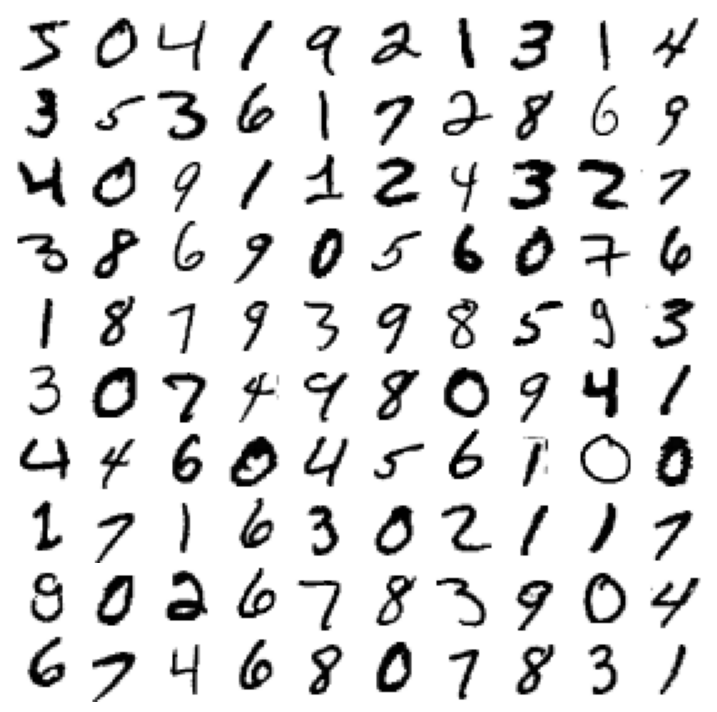

In [9]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [11]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now we'll pick a classifier and train it. For example a stochastic gradient descent "SGD"

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

some_digit = X[0] --> first digit of the dataset --> digit = 5

In [13]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case!

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9353 , 0.9632 , 0.94965])

For more control over the cross-validation you could alternatively

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9353
0.9632
0.94965


What would happen if we clasiffy every single image in the most frequent class, in this case the negative class (non 5)?

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Only about 10% of the images were 5s, so if you always guess that an image is not 5, you will be right about 90% of the time. This is why accuracy is generally not the preferred performance measure for classifiers

A better way to evaluate the performance of a classifier is the confusion matrix (CM)

### Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[52533,  2046],
       [  991,  4430]])

Each row represents an actual class, while each column represents a predicted class

- First row = non-5 images
- Second row = 5 images
- First column = Prediction of a non-5 image
- Second column = Prediction of  a 5 image

- 52533 images were correctly classified as non-5 (True Negatives)
- 2046 images were wrongly classified as a 5 beeing a non-5 (False Positives - type 1 error)
- 991 images were wrongly classified as a non-5 beeing a 5 (False Negatives - type 2 error)
- 4430 images were correctly classified as a 5 (True Positives)


This is how a perfect classifier would look like (only TN and TP):

In [20]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

precision = TP / (TP + FP); of all positives predicted, how many were true?

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 4430/(4430+2046)

0.6840642371834466

In [22]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.6840642371834466

recall = TP / (TP + FN); of all real positives, how many were correctly detected by the classifier?

In [23]:
recall_score(y_train_5, y_train_pred)  # == 4430 / (4430 + 991)

0.8171923999262128

In [24]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.8171923999262128

- When it claims an image represents a 5, it is correct 68% of the time (precision)
- It detects 81% of the 5s (recall)

To combine precision and recall into a single metric --> F1 score
- F1 score = harmonic mean of precision and recall (harmonic mean = it gives much more weight to low values)
- For a high F1 score, both recall and precision must be high

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7447255610658149

In [26]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7447255610658149

F1 favors classifiers that have similar precision and recall

In some cases, you will only care about precision and in other cases you will really care about recall

-  High precision --> all claims made were correct
- High recall --> it detects all the real positives

Increasing precision reduces recall, and vice versa --> precision/recall trade-off

### Precision/Recall Trade-off

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2871.11767087])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [29]:
y_some_digit_pred

array([ True])

It detects that the image is a 5 when threshold is set at 0

In [30]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

It misses that the image is a 5 when threshold is set at 3000

Therefore, raising the threshold decreases recall but increases precision, and vice versa
- How do you decide which threshold to use?

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

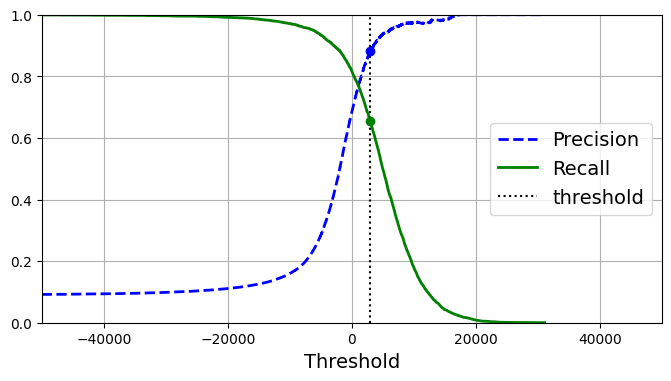

In [33]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall

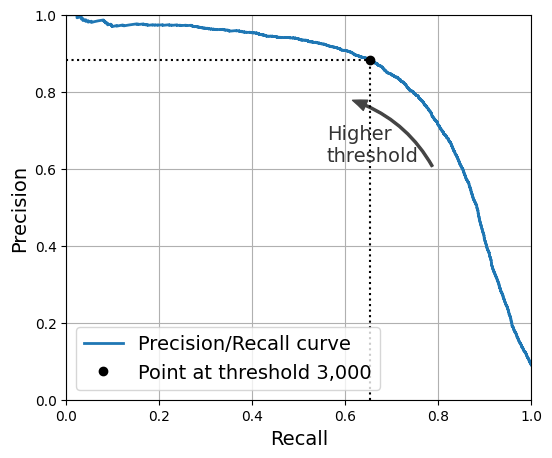

In [34]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

You can see on the plots what precision/recall trade-off you'd like and select the threshold accordingly
- This will depend on your project.

Suppose that after looking at the plot, you decide to aim for 90% precision. Then, you could search for the lowest threshold that gives you at least 90% precision (lowering the threshold increases recall):

In [35]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3533.1791790603324

To make predictions on the training set:

In [36]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Let's check predictions recall and precision

In [37]:
precision_score(y_train_5, y_train_pred_90)

0.9001888319395738

In [38]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.6155690831949825

### The ROC Curve

In [39]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

The ROC curve plots sensitivity (recall) against 1 - specificity (true negative rate)

- true negative rate (TNR) = ratio of negative instances correctly cassified as negative
- FPR (false positive rate or fall-out) = 1 - TNR --> ratio of negative instances incorrectly cassified as positive

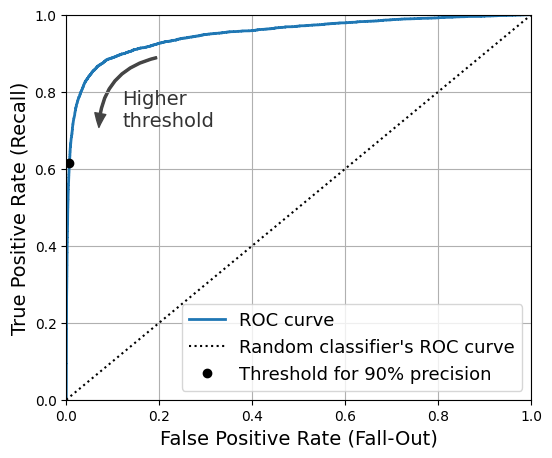

In [40]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

Trade off --> the higher the recall, the more false positives the classifier produces

One way to compare classifiers is to measure the area under the curve (AUC). 
- Perfect classifier --> AUC = 1
- Purely random classifier --> AUC = 0.5

In [41]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9506700868666318

How to decide if we use the precision/recall curve (PR) or the ROC curve?

- PR curve --> when the positive class is rare (not many real positives in the sample) or when you care more about the false positives than the false negatives.

- ROC curve --> Otherwise

e.g. looking at the AUC score, you may think that this classifier is very good, but this is because there are few positives (5s) compared to the negatives (non-5). See that the PR curve shows that the classifier has room for improvement (if curve moves to the right corner).

Let´s now create a RandomForestClassifier, whose PR curve and F1 score we can compare to the SGDClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [43]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [44]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

RandomForestClassifier does not have a decision_function() but instead it has a predict_proba() method that returns class probabilities for each instance.

- We can use the probability of the positive class as a score

y_probas_forest
- The model predicts that the first image is positive with 89% probability.
- It also predicts that the second image is negative with 99% probability.
- Since an image is etiher positive or negative, both probailities add up to 100%